## Víctor Cabré Guerrero


# Problema individual 4: Comprender o predecir, ¿es esa la cuestión?

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

import numpy as np

from skopt import BayesSearchCV
np.int = int

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

In [2]:
def save_results(clf, X_test, y_test, nclf, df): # funcion cedida por Javier Bejar
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

Cogemos los datos de sklearn.datasets utilizando la función fetch_openml, que nos devuelve un objeto Bunch. Accedemos a los datos de características y la variable objetivo indexándolos como si fueran un diccionario.

In [3]:
openml_data = fetch_openml("autos")

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name autos exist. Versions may be fundamentally different, returning version 1.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


Estos son los atributos que tenemos en el conjunto de datos (información extraída de https://www.openml.org/search?type=data&sort=runs&id=9&status=active)
    
1. symboling: -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses: continuous from 65 to 256.
3. make: alfa-romero, audi, bmw, chevrolet, dodge, honda, isuzu, jaguar, mazda, mercedes-benz, mercury, mitsubishi, nissan, peugot, plymouth, porsche, renault, saab, subaru, toyota, volkswagen, volvo
4. fuel-type: diesel, gas.
5. aspiration: std, turbo.
6. num-of-doors: four, two.
7. body-style: hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels: 4wd, fwd, rwd.
9. engine-location: front, rear.
10. wheel-base: continuous from 86.6 120.9.
11. length: continuous from 141.1 to 208.1.
12. width: continuous from 60.3 to 72.3.
13. height: continuous from 47.8 to 59.8.
14. curb-weight: continuous from 1488 to 4066.
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders: eight, five, four, six, three, twelve, two.
17. engine-size: continuous from 61 to 326.
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore: continuous from 2.54 to 3.94.
20. stroke: continuous from 2.07 to 4.17.
21. compression-ratio: continuous from 7 to 23.
22. horsepower: continuous from 48 to 288.
23. peak-rpm: continuous from 4150 to 6600.
24. city-mpg: continuous from 13 to 49.
25. highway-mpg: continuous from 16 to 54.
26. price: continuous from 5118 to 45400.


In [4]:
X = openml_data["data"]
y = openml_data["target"]

Vamos a hacer alguna visualización básica de los datos.

In [5]:
data_all = pd.concat([X, pd.DataFrame({"symboling":y})], axis=1)

In [6]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   normalized-losses  164 non-null    float64 
 1   make               205 non-null    category
 2   fuel-type          205 non-null    category
 3   aspiration         205 non-null    category
 4   num-of-doors       203 non-null    category
 5   body-style         205 non-null    category
 6   drive-wheels       205 non-null    category
 7   engine-location    205 non-null    category
 8   wheel-base         205 non-null    float64 
 9   length             205 non-null    float64 
 10  width              205 non-null    float64 
 11  height             205 non-null    float64 
 12  curb-weight        205 non-null    float64 
 13  engine-type        205 non-null    category
 14  num-of-cylinders   205 non-null    category
 15  engine-size        205 non-null    float64 
 16  fuel-sys

In [7]:
data_all.head(10)

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0,2
5,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,15250.0,2
6,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,17710.0,1
7,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,18920.0,1
8,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,...,mpfi,3.13,3.40,8.3,140.0,5500.0,17.0,20.0,23875.0,1
9,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,...,mpfi,3.13,3.40,7.0,160.0,5500.0,16.0,22.0,NaN,0


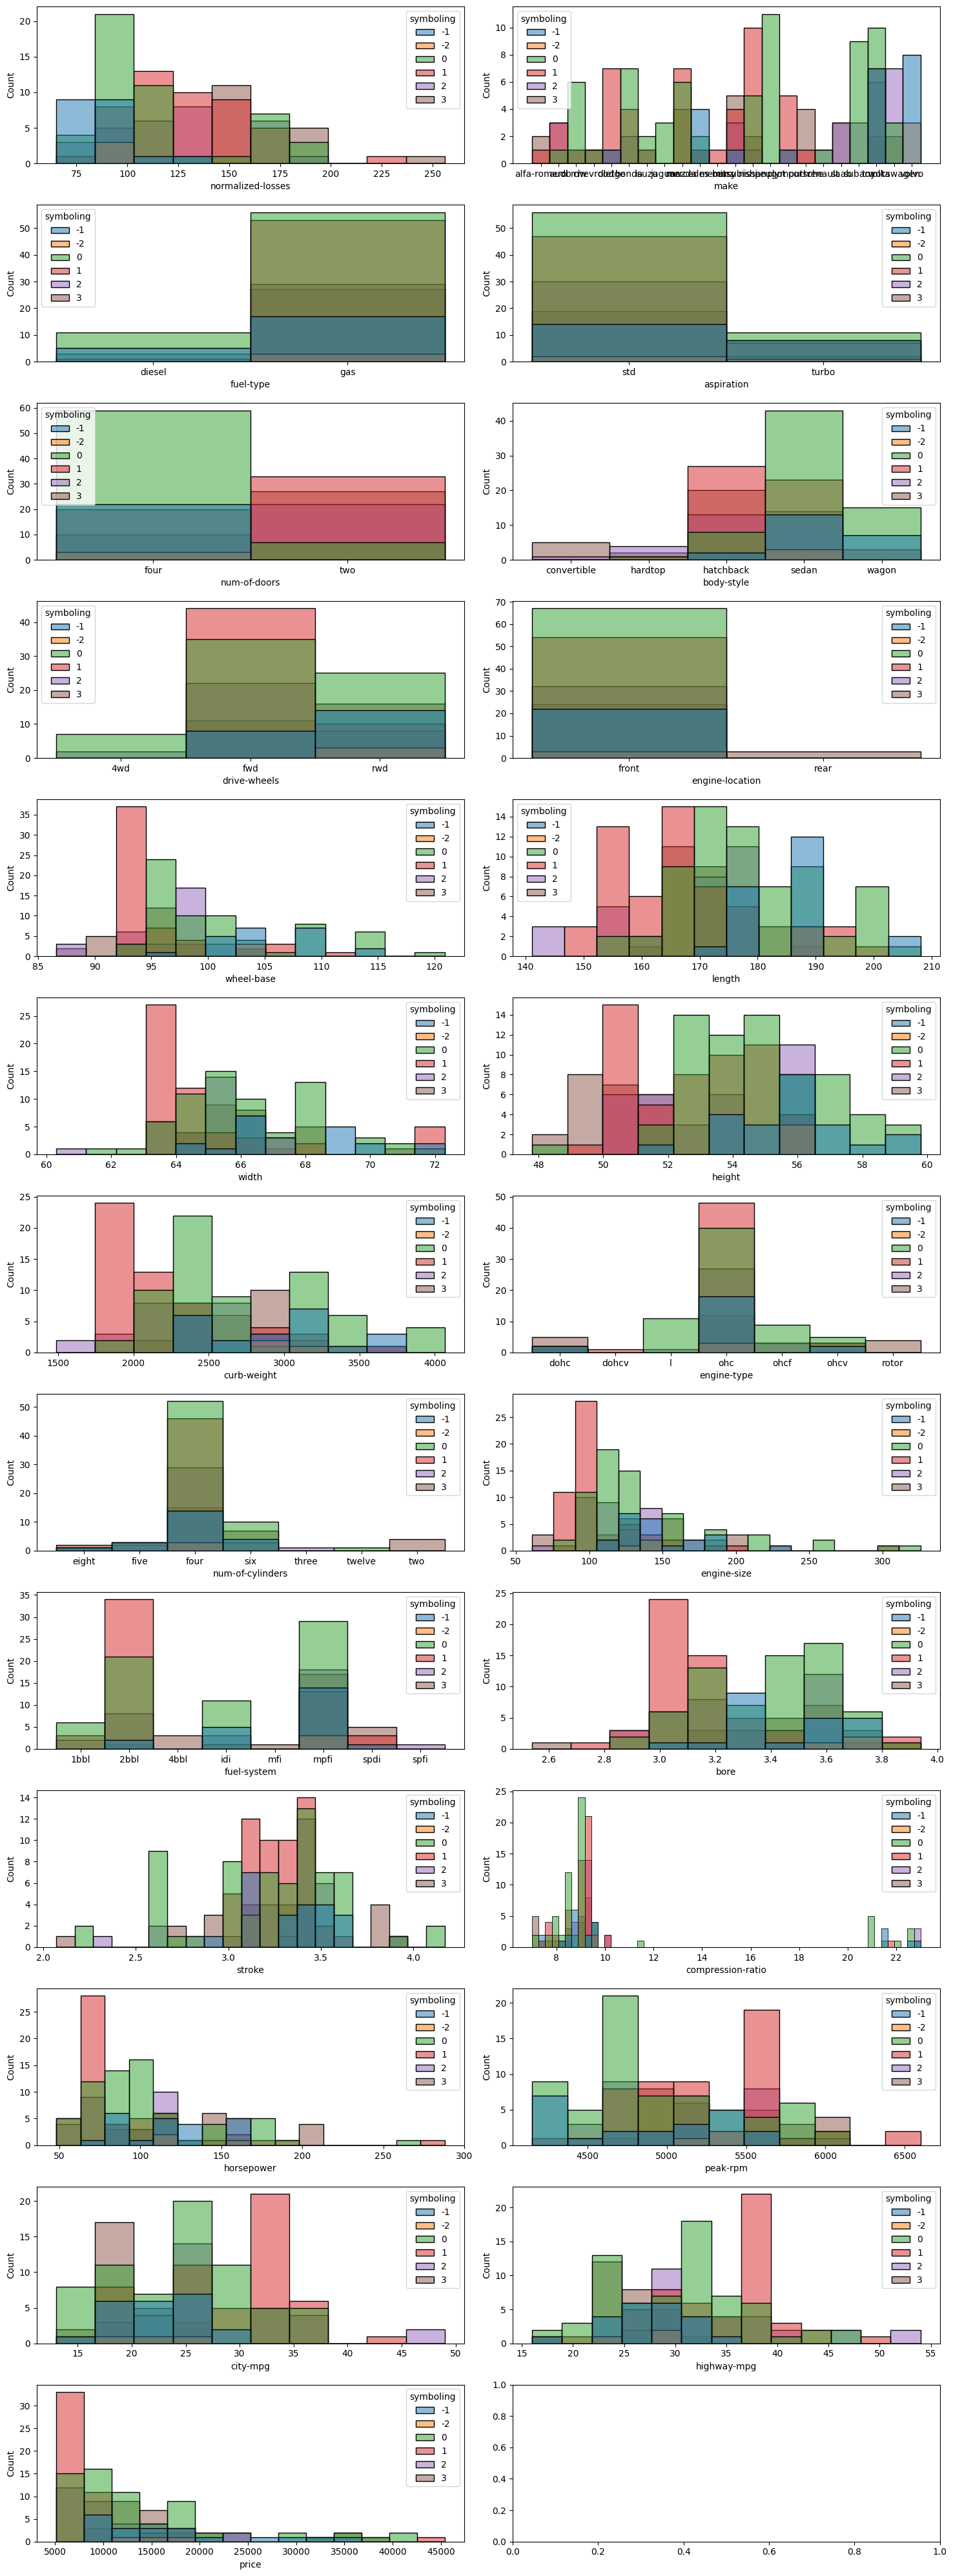

In [8]:
fig, axes = plt.subplots(13,2,figsize=(15,40))

for i, c in enumerate(X.columns):
    ax = axes.reshape(-1)[i]
    b = sns.histplot(x=c,data=X,ax=ax, hue=y, palette='tab10')
plt.tight_layout()

Tenemos un total de 205 ejemplos. Vemos que tenemos bastantes valores faltantes, especialmente en el atributo normalized-losses, donde tenemos más de 40 valores faltantes.

In [9]:
X.isna().sum()

normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [10]:
y.isna().sum()

0

### Preprocesado de los datos

Transformamos el atributo objetivo symboling en dos categorías, 0 si el valor es mejor o igual a 0 (riesgo bajo), y 1 si es mayor que 0 (riesgo alto).

In [11]:
y = y.astype(int).apply(lambda x: 0 if x <= 0 else 1)

Separamos el conjunto de características en dos conjuntos diferentes, uno con las variables categóricas y otro con las variables contínuas.

In [12]:
X_categorical = X.select_dtypes(include=["category"])
X_continuous = X.select_dtypes(exclude=["category"])

In [13]:
X_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   make              205 non-null    category
 1   fuel-type         205 non-null    category
 2   aspiration        205 non-null    category
 3   num-of-doors      203 non-null    category
 4   body-style        205 non-null    category
 5   drive-wheels      205 non-null    category
 6   engine-location   205 non-null    category
 7   engine-type       205 non-null    category
 8   num-of-cylinders  205 non-null    category
 9   fuel-system       205 non-null    category
dtypes: category(10)
memory usage: 4.7 KB


In [14]:
X_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    float64
 6   engine-size        205 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-ratio  205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak-rpm           203 non-null    float64
 12  city-mpg           205 non-null    float64
 13  highway-mpg        205 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 24.2 KB


Binarizamos los atributos categóricos. Solamente tenemos dos valores faltantes en el conjunto de datos categóricos. Es una proporción muy pequeña respecto al total de más de 200 ejemplos, así que los vamos a ignorar.

In [15]:
X_categorical.isna().sum()

make                0
fuel-type           0
aspiration          0
num-of-doors        2
body-style          0
drive-wheels        0
engine-location     0
engine-type         0
num-of-cylinders    0
fuel-system         0
dtype: int64

In [16]:
NaN_rows_categorical = X_categorical[X_categorical.isna().any(axis=1)].index

X_continuous = X_continuous.drop(index=NaN_rows_categorical)
y = y.drop(index=NaN_rows_categorical)
X_categorical = X_categorical.dropna()

In [17]:
X_categorical_dummies = pd.get_dummies(X_categorical, drop_first=True)
X_categorical_dummies

,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,...,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
201,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
202,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
203,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


Imputamos los valores faltantes en el conjunto de datos continuos. Utilizaremos K vecinos más cercanos. Como tenemos que ajustar el KNNImputer, vamos a primero separar los datos en conjunto de entrenamiento y test para no sesgar nuestros resultados.

In [18]:
X_cat_train, X_cat_test, X_cont_train, X_cont_test, y_train, y_test = train_test_split(
    X_categorical_dummies, X_continuous, y, test_size=0.4, random_state=4096, stratify=y)

In [19]:
knn_imputer = KNNImputer(n_neighbors=5)

X_cont_train = pd.DataFrame(knn_imputer.fit_transform(X_cont_train), columns=X_cont_train.columns)
X_cont_test = pd.DataFrame(knn_imputer.transform(X_cont_test), columns=X_cont_train.columns)

### Ajuste de un árbol de decisión utilizando los datos categóricos

In [20]:
cv=10
iter=40

param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt_cat =  DecisionTreeClassifier(random_state=0)
dt_bs_cat =  BayesSearchCV(dt_cat,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_bs_cat.fit(X_cat_train, y_train);

In [21]:
pd.DataFrame(dt_bs_cat.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
32,"{'criterion': 'gini', 'max_depth': 9, 'max_lea...",0.883974,1
35,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.875641,2
26,"{'criterion': 'entropy', 'max_depth': 9, 'max_...",0.875641,2
11,"{'criterion': 'entropy', 'max_depth': 6, 'max_...",0.875641,2
27,"{'criterion': 'gini', 'max_depth': 3, 'max_lea...",0.875000,5


Observamos que el mejor modelo tiene un acierto de validación del 88%, que está bastante bien. Vamos a fijarnos en los valores de precisión y recuperación para cada clase, y los valores globales de acierto del modelo con los datos de test.

In [22]:
print(classification_report(y_test, dt_bs_cat.predict(X_cat_test)))
results_df = save_results(dt_bs_cat, X_cat_test, y_test, 'Datos categóricos', results_df)

              precision    recall  f1-score   support

           0       0.71      0.86      0.78        37
           1       0.86      0.71      0.78        45

    accuracy                           0.78        82
   macro avg       0.79      0.79      0.78        82
weighted avg       0.80      0.78      0.78        82



Observamos que las predicciones en el conjunto de test para cada clase son bastante buenas. El f1 score de ambas clases es el mismo, y tanto la precisión como la recuperación es muy alta.

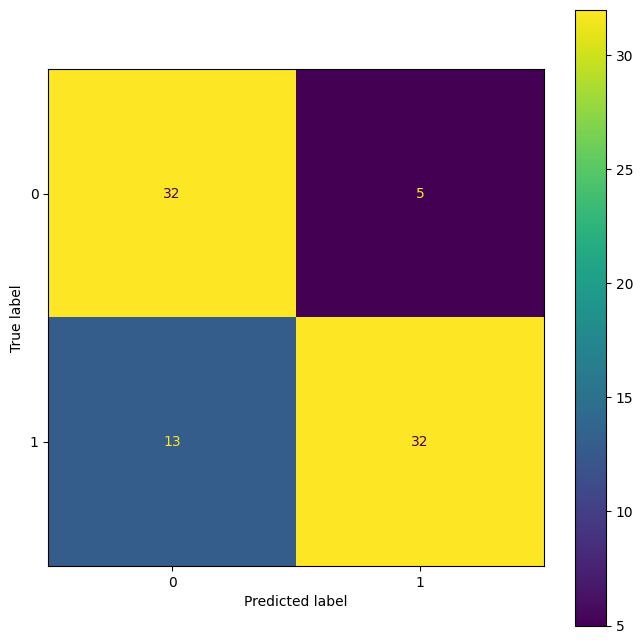

In [23]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs_cat, X_cat_test,y_test, ax=plt.subplot());

Visualizamos ahora el árbol de decisión para entender las decisiones que se toman en cada bifurcación.

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:291: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6839: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6854: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


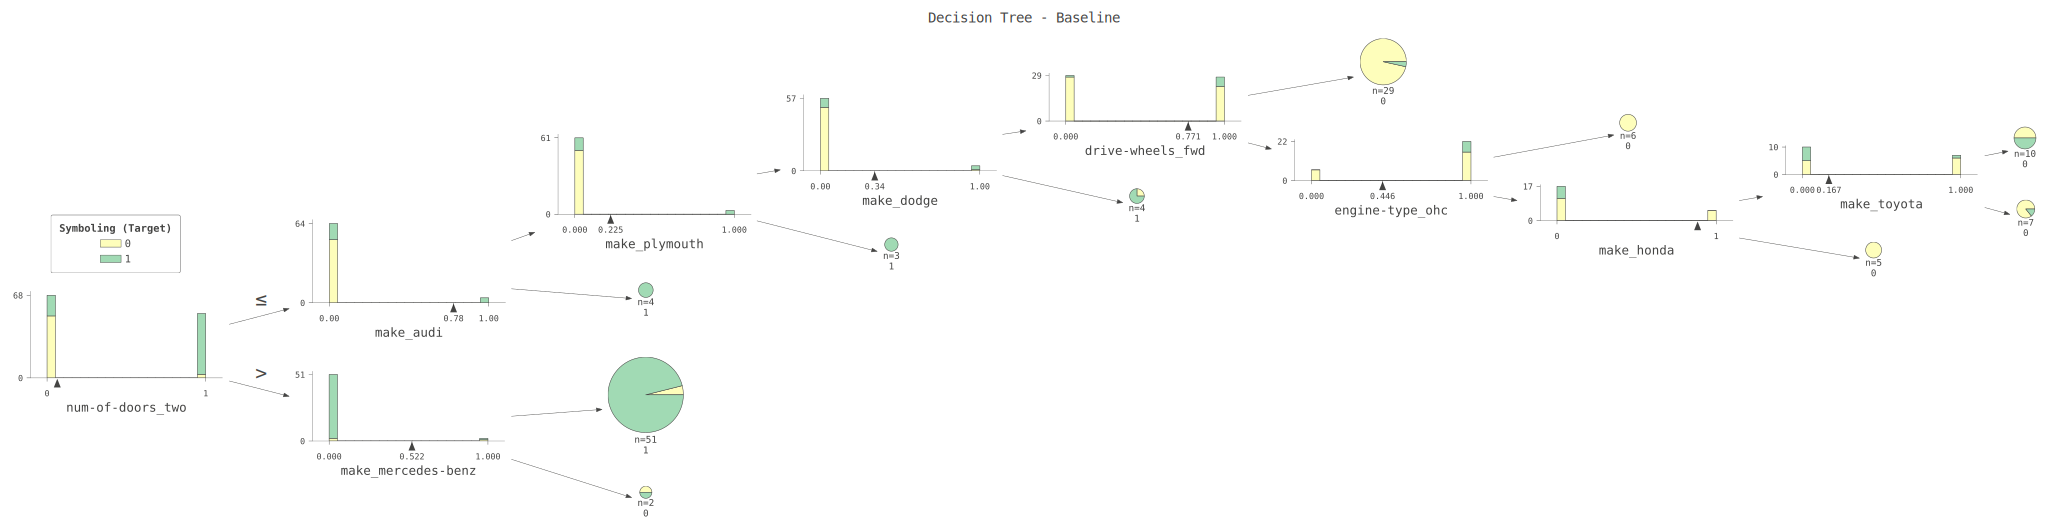

In [24]:
v_model = dtreeviz.model(dt_bs_cat.best_estimator_, 
               X_train=X_cat_train,
               y_train=y_train,
               target_name='Symboling (Target)',
               feature_names=X_cat_train.columns,
               class_names=[0,1]
               )
v_model.view(fontname="monospace", scale=1.5, title="Decision Tree - Baseline",orientation='LR')

Vemos que es un árbol de decisión de complejidad media, con bastantes niveles. Las decisiones que toma el modelo se basan, sobre todo, en el número de puertas del vehículo. En general, la mayoría de coches con dos puertas (que tienden a ser coches deportivos con motores potentes) son de riesgo. Dentro de los coches que no son de riesgo, el modelo diferencia diferentes marcas, como por ejemplo Audi, Plymouth y Dodge, para determinar si son de riesgo o no lo son.

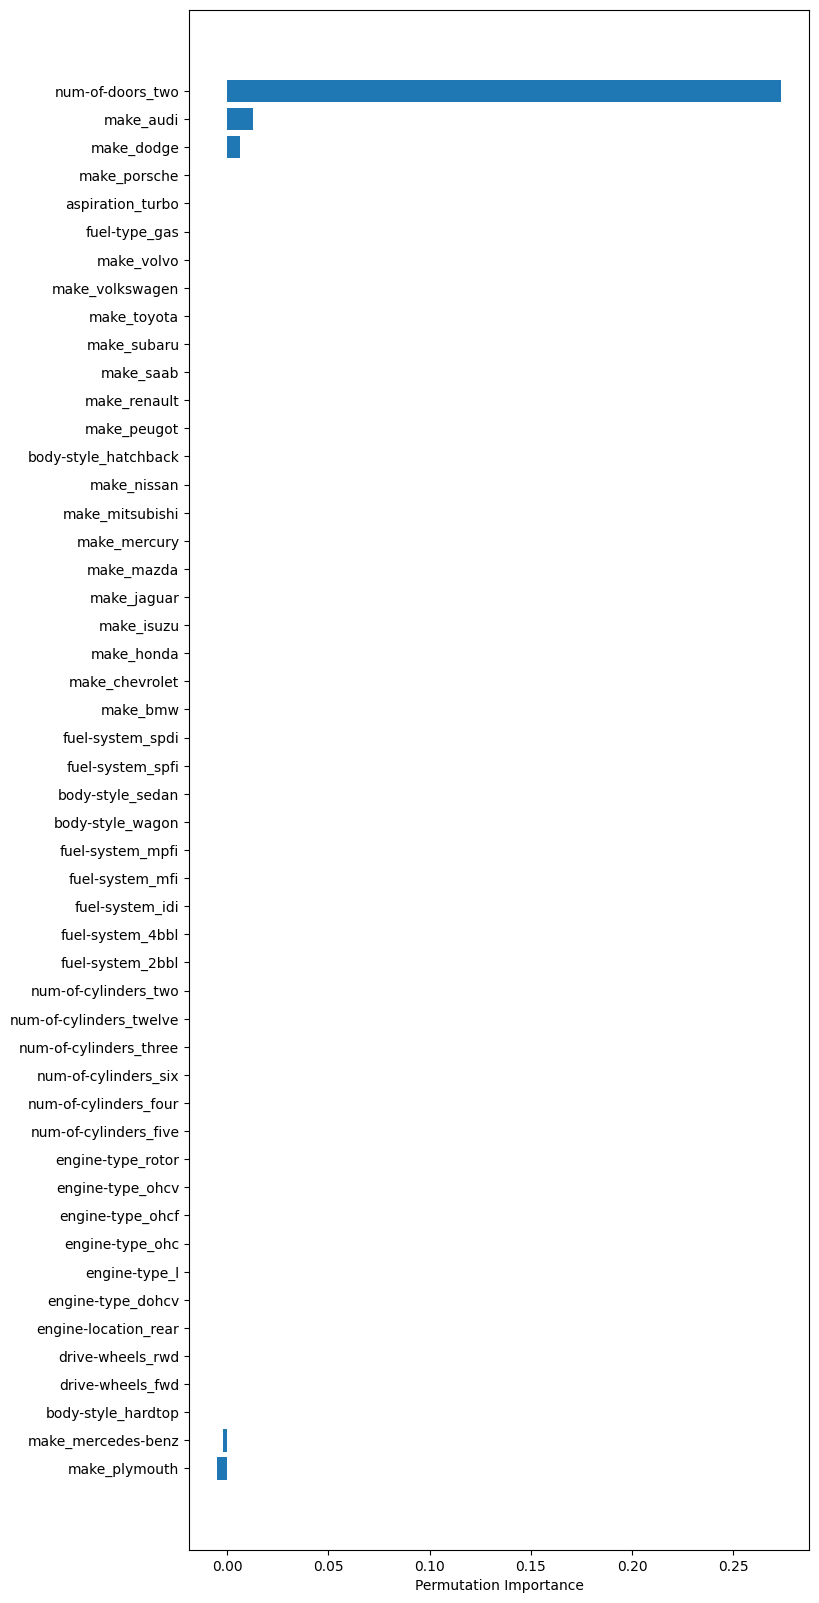

In [25]:
result = permutation_importance(dt_bs_cat.best_estimator_, X_cat_test, y_test, n_repeats=30, random_state=0)

plt.figure(figsize=(8,20))
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X_cat_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_cat_test.shape[1]), X_cat_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

### Ajuste de un árbol de decisión utilizando los datos continuos

In [26]:
cv=10
iter=40

param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt_cont =  DecisionTreeClassifier(random_state=0)
dt_bs_cont =  BayesSearchCV(dt_cont,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_bs_cont.fit(X_cont_train, y_train);

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.


In [27]:
pd.DataFrame(dt_bs_cont.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
37,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.867949,1
36,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.867949,1
33,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.867949,1
32,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.867949,1
11,"{'criterion': 'entropy', 'max_depth': 6, 'max_...",0.850641,5


In [28]:
print(classification_report(y_test, dt_bs_cont.predict(X_cont_test)))
results_df = save_results(dt_bs_cont, X_cont_test, y_test, 'Datos continuos', results_df)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        37
           1       0.84      0.80      0.82        45

    accuracy                           0.80        82
   macro avg       0.80      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82



Este modelo también tiene un acierto bastante alto, casi del 87%. Tanto la recuperación como la precisión en ambas clases es buena.

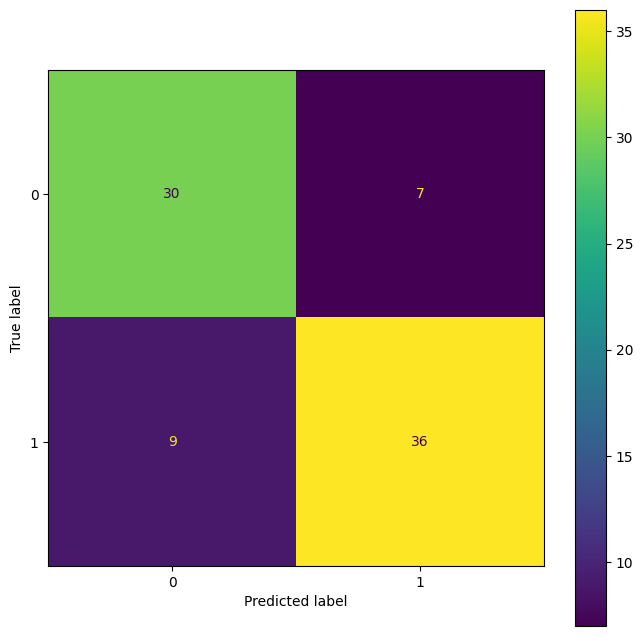

In [29]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs_cont, X_cont_test,y_test, ax=plt.subplot());

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


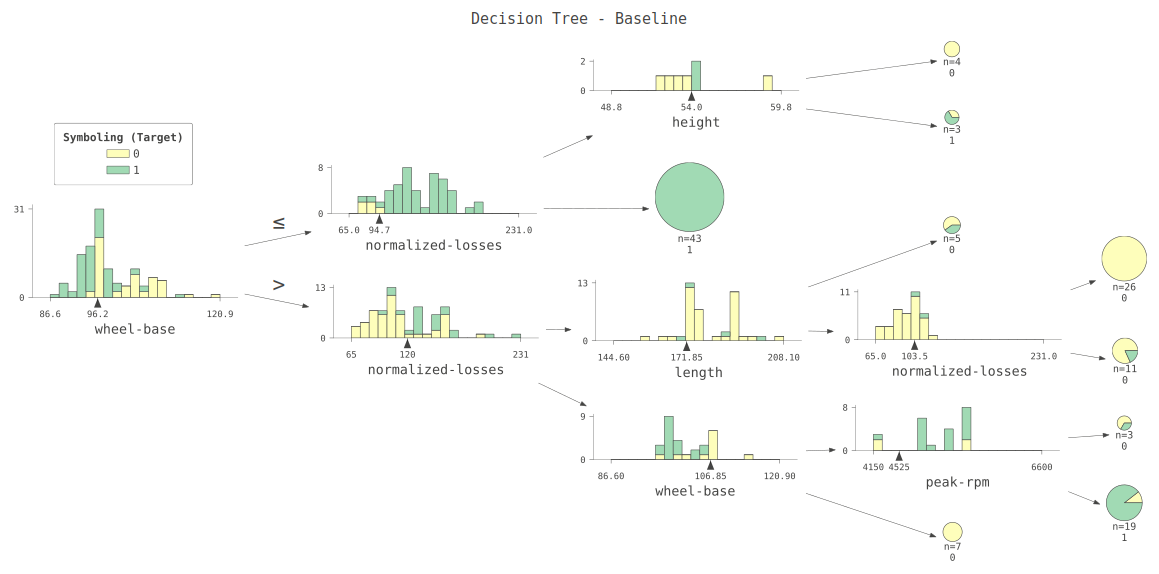

In [30]:
v_model = dtreeviz.model(dt_bs_cont.best_estimator_, 
               X_train=X_cont_train,
               y_train=y_train,
               target_name='Symboling (Target)',
               feature_names=X_cont_train.columns,
               class_names=[0,1]
               )
v_model.view(fontname="monospace", scale=1.5, title="Decision Tree - Baseline",orientation='LR')

Vemos que es un árbol de decisión de complejidad media, con bastantes niveles. Las decisiones que toma el modelo se basan principalmente en los atributos wheel-base y normalized-losses.

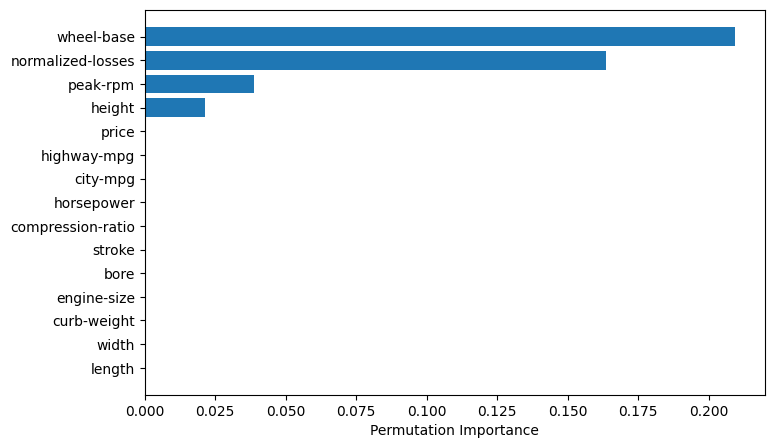

In [31]:
result = permutation_importance(dt_bs_cont.best_estimator_, X_cont_test, y_test, n_repeats=30, random_state=0)

plt.figure(figsize=(8,5))
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X_cont_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_cont_test.shape[1]), X_cont_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

### Elección del modelo: ¿Datos categóricos o continuos?

In [32]:
results_df

,train XV acc,test acc,test f1 score (0),test f1 score (1),test f1 score (W),ROC AUC
Datos categóricos,0.883974,0.780488,0.780488,0.780488,0.780488,0.860961
Datos continuos,0.867949,0.804878,0.789474,0.818182,0.803828,0.868468


Los resultados de ambos árboles de decisión son muy parecidos. El árbol con variables continuas tiene un área debajo la curva (AOC) ligeramente superior a la de los datos categóricos y un f1 score en test que es 2 puntos mejor que la del modelo catégorico. Por otro lado, el modelo categórico ofrece más interpretabilidad: es más fácil de interpretar, por ejemplo, que los coches con dos puertas tienen más riesgo inherente que los de cuatro puertas. Las decisiones con valores continuos deciden unas barreras un poco arbitrarias, como por ejemplo si wheel-base es menor o mayor que 96.2 (¿por qué 96.2, y no 96.5?).

Dado que ambos modelos dan resultados muy similares, elegiría el que utiliza variables categóricas, debido a su mayor interpretabilidad.

### Ajuste de un árbol de decisión utilizando todos los datos

In [33]:
X_train = pd.concat([X_cat_train.reset_index(drop=True), X_cont_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_cat_test.reset_index(drop=True), X_cont_test.reset_index(drop=True)], axis=1)

In [34]:
cv=10
iter=40

param = {'criterion':['gini', 'entropy'], 
         'max_depth':[1, 2, 3, 4],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt_all =  DecisionTreeClassifier(random_state=0)
dt_bs_all =  BayesSearchCV(dt_all,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
dt_bs_all.fit(X_train, y_train);

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/hom

In [35]:
pd.DataFrame(dt_bs_all.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
32,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.942308,1
26,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.942308,1
29,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.942308,1
5,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.942308,1
38,"{'criterion': 'gini', 'max_depth': 4, 'max_lea...",0.942308,1


In [36]:
print(classification_report(y_test, dt_bs_all.predict(X_test)))
results_df = save_results(dt_bs_all, X_test, y_test, 'Todos los datos', results_df)

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        37
           1       0.81      0.78      0.80        45

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82



Vemos que este modelo mejora considerablemente el acierto en los datos de entrenamiento. Tanto la precisión como la recuperación no han cambiado mucho respecto a los dos modelos anteriores. El modelo tiene más información, y puede combinar decisiones con variables categóricas, como por ejemplo si el coche tiene dos puertas, con información continua, como la potencia del motor. Esto es posible que le permite al modelo tener una visión más global del problema. No obstante, parece que el modelo está sobreespecializandose en los datos de entrenamiento, y da unos resultados en el conjunto de test un poco peores respecto a los otros modelos.

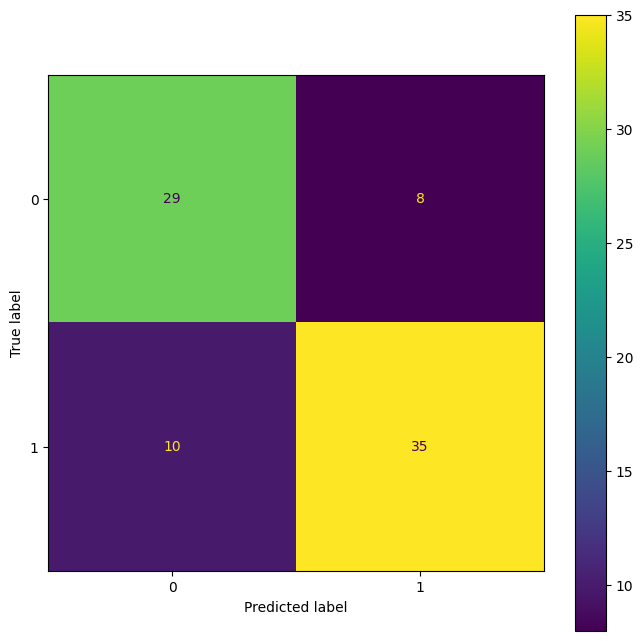

In [37]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs_all, X_test, y_test, ax=plt.subplot());

/home/victor/Documents/APA/apaVenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


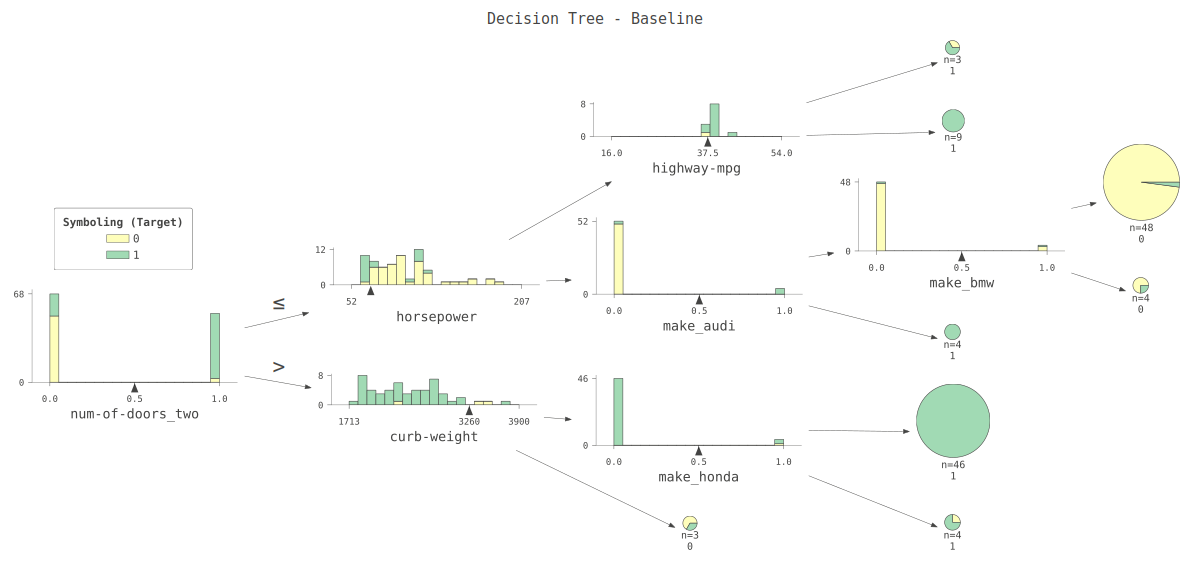

In [38]:
v_model = dtreeviz.model(dt_bs_all.best_estimator_, 
               X_train=X_train,
               y_train=y_train,
               target_name='Symboling (Target)',
               feature_names=X_train.columns,
               class_names=[0,1]
               )
v_model.view(fontname="monospace", scale=1.5, title="Decision Tree - Baseline",orientation='LR')

Ahora el modelo es un poco más complejo. Otra vez, el número de puertas es un atributo muy importante. Otros atributos a los que el modelo les ha dado relevacia son la potencia del motor en caballos, curb-weight y si el coche es de la marca Audi.

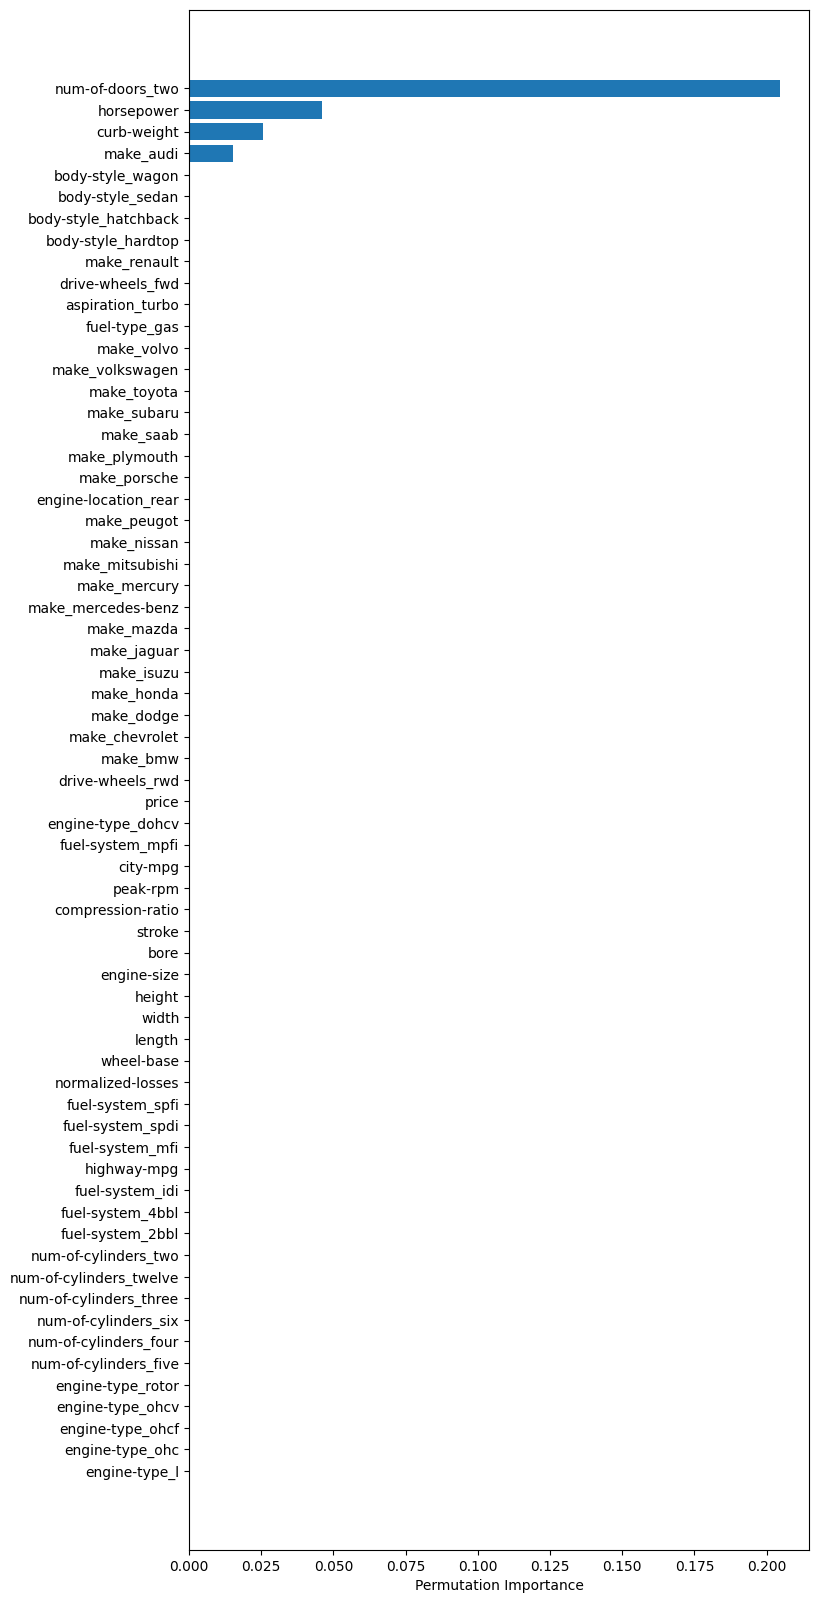

In [39]:
result = permutation_importance(dt_bs_all.best_estimator_, X_test, y_test, n_repeats=30, random_state=0)

plt.figure(figsize=(8,20))
sorted_idx = result.importances_mean.argsort()
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

### Elección del modelo: ¿Categóricos, continuos o todos los datos?

In [40]:
results_df

,train XV acc,test acc,test f1 score (0),test f1 score (1),test f1 score (W),ROC AUC
Datos categóricos,0.883974,0.780488,0.780488,0.780488,0.780488,0.860961
Datos continuos,0.867949,0.804878,0.789474,0.818182,0.803828,0.868468
Todos los datos,0.942308,0.780488,0.763158,0.795455,0.779306,0.824925


El modelo con los todos los datos no consigue superar en rendimiento al que utiliza datos continuos. La elección del modelo final depende de si queremos predicciones ligeramente mejores o queremos más explicabilidad. En el primer caso, deberíamos elegir el modelo con datos continuos. Si queremos más explicabilidad, el modelo con datos categóricos es más adecuado, por los motivos explicados anteriormente.